In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable
import seaborn as sns

In [58]:
data = pd.read_csv("tweets_airline.csv", usecols=['airline_sentiment', 'text'])

In [59]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [61]:
def cleaning(text: str) -> str:
    patterns = [r'@[A-Za-z0-9-_]+',  
                r'http[s]?://\S+',
                r'#[A-Za-z0-9_]+',
                r'[0-9]+',
                r'<.*?>',
                r'[^\w\s]',
                r'_']
    text = re.sub('|'.join(patterns), '', text)
    text = " ".join(text.split()).lower()
    return text

def stop_words(stem_words: list) -> list[str]:
    stopwords_en = stopwords.words('english')
    new_list = []
    for word in stem_words:
        if word not in stopwords_en:
            new_list.append(word)
    return new_list


def stemming(text: str) -> list[str]:
    word_tokens = word_tokenize(text)
    porter = PorterStemmer()
    stem_words = []
    for w in word_tokens:
        stem_words.append(porter.stem(w))
    return stem_words


def text_tokenizer(text: str) -> list:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return new_wordlist

def word_count(text: str) -> dict:
    word_tokens = word_tokenize(text)
    counts = dict()
    for word in word_tokens:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def cleaning_for_visualization(text: str) -> str:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return " ".join(new_wordlist) 

def visualization(data, title):
    plt.figure(figsize=(12,6))
    colors = ['#003f5c','#58508d', '#bc5090']
    data.plot.barh(title=title, color=np.random.choice(colors), legend=None).invert_yaxis()
    plt.xlabel("Count")
    plt.ylabel("Token")
    plt.show()
    pretty_table = PrettyTable()
    pretty_table.title = title
    pretty_table.add_column("Token", data.index)
    pretty_table.add_column("Count", data.iloc[:, 0])
    print(pretty_table)

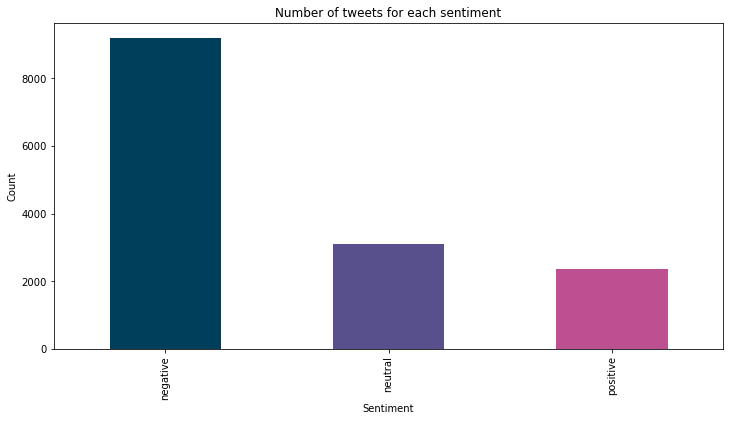

+-----------+-------+
| Sentiment | Count |
+-----------+-------+
|  negative |  9178 |
|  neutral  |  3099 |
|  positive |  2363 |
+-----------+-------+


In [62]:
plt.figure(figsize=(12,6))
plt.title("Number of tweets for each sentiment")
colors = ['#003f5c','#58508d', '#bc5090']
data['airline_sentiment'].value_counts().plot.bar(color=colors, legend=None)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
pretty_table = PrettyTable()
pretty_table.add_column("Sentiment", data['airline_sentiment'].value_counts().index)
pretty_table.add_column("Count", data['airline_sentiment'].value_counts().values)
print(pretty_table)

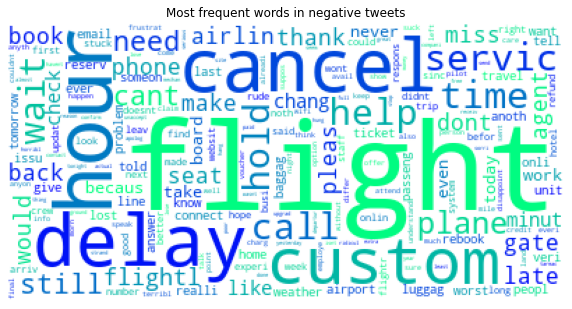

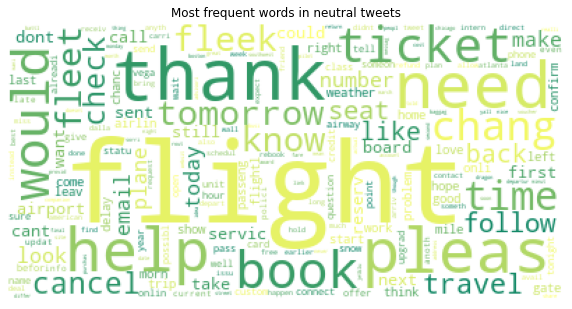

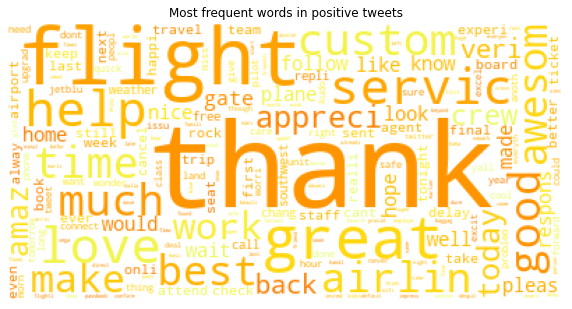

In [63]:
data_wordcloud = data.copy()
data_wordcloud['text'] = data_wordcloud['text'].apply(cleaning_for_visualization)

colormap = ['winter', "summer", "Wistia"]
sentiments = ['negative', 'neutral', 'positive']

for sentiment, theme in zip(sentiments, colormap):
    text = data_wordcloud.query('airline_sentiment == @sentiment')['text'].str.cat(sep=' ')
    plt.figure(figsize=[10, 8])
    wc = WordCloud(background_color="white", colormap=theme)
    wc.generate_from_frequencies(word_count(text))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Most frequent words in {sentiment} tweets")
    plt.show()

In [64]:
data_positive = data[data['airline_sentiment'] == 'positive']
data_neutral = data[data['airline_sentiment'] == 'neutral']
data_negative = data[data['airline_sentiment'] == 'negative']

count_vec = CountVectorizer(tokenizer=text_tokenizer) 
count_vec1 = CountVectorizer(tokenizer=text_tokenizer)
count_vec2 = CountVectorizer(tokenizer=text_tokenizer)
X_transform_positive = count_vec.fit_transform(data_positive['text'])
X_transform_neutral = count_vec1.fit_transform(data_neutral['text'])
X_transform_negative = count_vec2.fit_transform(data_negative['text'])

In [65]:
tokens_count_positive = pd.DataFrame(X_transform_positive.sum(axis=0), columns=count_vec.get_feature_names())
tokens_count_neutral = pd.DataFrame(X_transform_neutral.sum(axis=0), columns=count_vec1.get_feature_names())
tokens_count_negative = pd.DataFrame(X_transform_negative.sum(axis=0), columns=count_vec2.get_feature_names())

<Figure size 864x432 with 0 Axes>

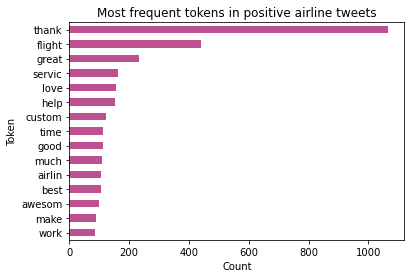

+--------------------------------------+
| Most frequent tokens in positive airline tweets |
+--------------------+-----------------+
|       Token        |      Count      |
+--------------------+-----------------+
|       thank        |       1067      |
|       flight       |       441       |
|       great        |       233       |
|       servic       |       161       |
|        love        |       157       |
|        help        |       153       |
|       custom       |       122       |
|        time        |       111       |
|        good        |       111       |
|        much        |       109       |
|       airlin       |       105       |
|        best        |       104       |
|       awesom       |        99       |
|        make        |        90       |
|        work        |        85       |
+--------------------+-----------------+


<Figure size 864x432 with 0 Axes>

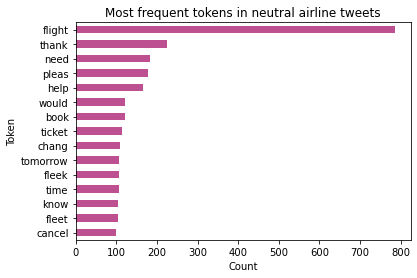

+-----------------------------------------+
| Most frequent tokens in neutral airline tweets |
+------------------------+----------------+
|         Token          |     Count      |
+------------------------+----------------+
|         flight         |      785       |
|         thank          |      224       |
|          need          |      184       |
|         pleas          |      178       |
|          help          |      165       |
|         would          |      122       |
|          book          |      122       |
|         ticket         |      113       |
|         chang          |      110       |
|        tomorrow        |      106       |
|         fleek          |      106       |
|          time          |      106       |
|          know          |      104       |
|         fleet          |      103       |
|         cancel         |       98       |
+------------------------+----------------+


<Figure size 864x432 with 0 Axes>

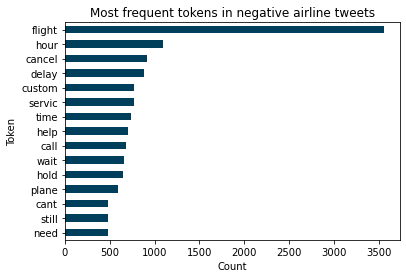

+--------------------------------------+
| Most frequent tokens in negative airline tweets |
+--------------------+-----------------+
|       Token        |      Count      |
+--------------------+-----------------+
|       flight       |       3554      |
|        hour        |       1097      |
|       cancel       |       913       |
|       delay        |       882       |
|       custom       |       773       |
|       servic       |       767       |
|        time        |       743       |
|        help        |       706       |
|        call        |       683       |
|        wait        |       662       |
|        hold        |       648       |
|       plane        |       589       |
|        cant        |       486       |
|       still        |       482       |
|        need        |       476       |
+--------------------+-----------------+


In [66]:
visualization(tokens_count_positive.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in positive airline tweets")
visualization(tokens_count_neutral.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in neutral airline tweets")
visualization(tokens_count_negative.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in negative airline tweets")

In [67]:
tfidf_vec = TfidfVectorizer(tokenizer=text_tokenizer) 
count_vec_all = CountVectorizer(tokenizer=text_tokenizer)
X_transform_tfidf = tfidf_vec.fit_transform(data['text'])
X_transform_count_all = count_vec_all.fit_transform(data['text'])

In [38]:
tokens_importance = pd.DataFrame(X_transform_tfidf.sum(axis=0), columns=tfidf_vec.get_feature_names())
tokens_count = pd.DataFrame(X_transform_count_all.sum(axis=0), columns=count_vec_all.get_feature_names())

<Figure size 864x432 with 0 Axes>

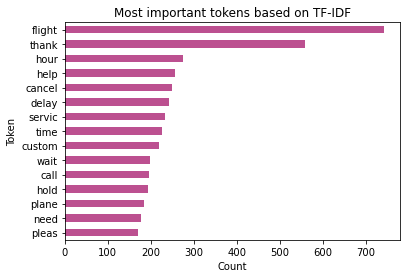

+---------------------------------------+
| Most important tokens based on TF-IDF |
+-----------+---------------------------+
|   Token   |           Count           |
+-----------+---------------------------+
|   flight  |     741.7469125944787     |
|   thank   |     558.5701913937285     |
|    hour   |     274.49967260925274    |
|    help   |     256.24331937270426    |
|   cancel  |     248.5407883035313     |
|   delay   |     243.4557672550858     |
|   servic  |     232.68598603010713    |
|    time   |     225.95138006819658    |
|   custom  |     220.15029229319265    |
|    wait   |     199.0057466756756     |
|    call   |     194.78725500927177    |
|    hold   |     194.2578603037967     |
|   plane   |     185.21163334259586    |
|    need   |     177.9546696770082     |
|   pleas   |     171.2658230033988     |
+-----------+---------------------------+


<Figure size 864x432 with 0 Axes>

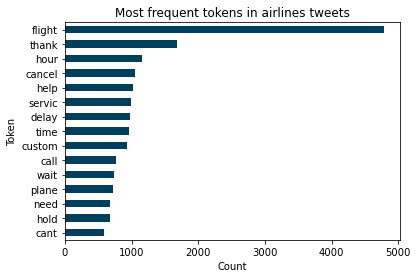

+----------------------------------+
| Most frequent tokens in airlines tweets |
+------------------+---------------+
|      Token       |     Count     |
+------------------+---------------+
|      flight      |      4780     |
|      thank       |      1682     |
|       hour       |      1151     |
|      cancel      |      1048     |
|       help       |      1024     |
|      servic      |      990      |
|      delay       |      970      |
|       time       |      960      |
|      custom      |      933      |
|       call       |      768      |
|       wait       |      744      |
|      plane       |      720      |
|       need       |      684      |
|       hold       |      681      |
|       cant       |      580      |
+------------------+---------------+


In [41]:
visualization(tokens_importance.T.sort_values(by=0, ascending=False).head(15), "Most important tokens based on TF-IDF")
visualization(tokens_count.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in airlines tweets")

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'],
                                                    test_size=0.3, shuffle=True, stratify=data['airline_sentiment'])

In [69]:
vectorizer = CountVectorizer(tokenizer=text_tokenizer)
count_train = vectorizer.fit_transform(X_train)
count_test = vectorizer.transform(X_test)

In [70]:
X_train.shape

(10248,)

In [71]:
X_test.shape

(4392,)

In [72]:
def heatmap(y_test, y_pred, classifier): 
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='g'),
    ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'{classifier} Confusion Matrix')
    plt.show()

Random Forest Model 
               precision    recall  f1-score   support

    negative       0.82      0.85      0.84      2753
     neutral       0.56      0.54      0.55       930
    positive       0.67      0.62      0.64       709

    accuracy                           0.75      4392
   macro avg       0.68      0.67      0.68      4392
weighted avg       0.74      0.75      0.75      4392



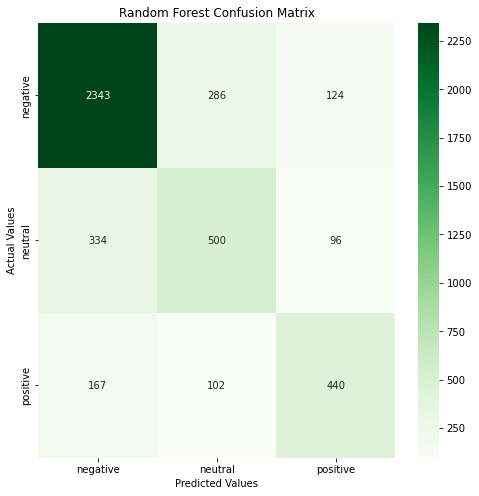

In [73]:
rfc_model = RandomForestClassifier()
rfc_model.fit(count_train, y_train)
rfc_predict = rfc_model.predict(count_test)
print(f'Random Forest Model \n {classification_report(y_test, rfc_predict)}')
heatmap(y_test, rfc_predict, "Random Forest")

SVM Model 
               precision    recall  f1-score   support

    negative       0.84      0.85      0.84      2753
     neutral       0.55      0.54      0.55       930
    positive       0.66      0.64      0.65       709

    accuracy                           0.75      4392
   macro avg       0.68      0.68      0.68      4392
weighted avg       0.75      0.75      0.75      4392



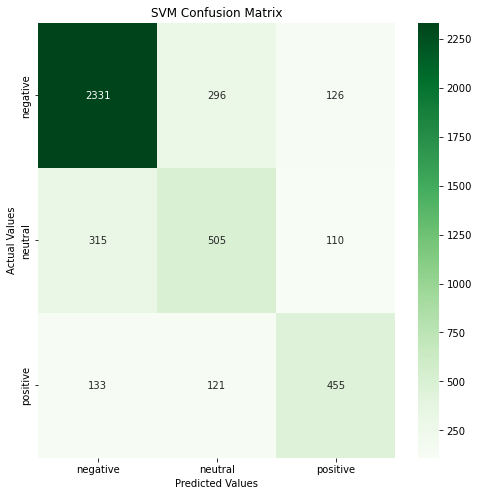

In [76]:
svm_model = LinearSVC(max_iter=3000)
svm_model.fit(count_train, y_train)
svm_predict = svm_model.predict(count_test)
print(f'SVM Model \n {classification_report(y_test, svm_predict)}')
heatmap(y_test, svm_predict, "SVM")

MLP Classifier Model 
               precision    recall  f1-score   support

    negative       0.84      0.88      0.86      2753
     neutral       0.59      0.56      0.58       930
    positive       0.72      0.64      0.68       709

    accuracy                           0.77      4392
   macro avg       0.72      0.70      0.71      4392
weighted avg       0.77      0.77      0.77      4392



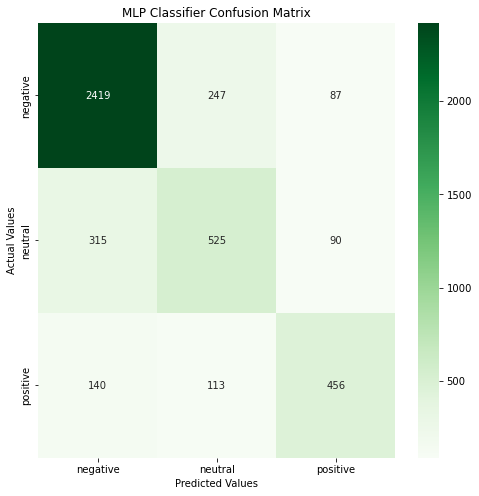

In [75]:
mlp=MLPClassifier(early_stopping=True)
mlp.fit(count_train, y_train)
mlp_predict=mlp.predict(count_test)
print(f'MLP Classifier Model \n {classification_report(y_test, mlp_predict)}')
heatmap(y_test, mlp_predict, "MLP Classifier")

Największą dokładność uzyskał MLP Classifier - 77%.

Precision:
- Spośród wszystkich tweetów zaklasyfikowanych jako negatywne około 84% zostało przewidzianych poprawnie.
- Spośród wszystkich tweetów zaklasyfikowanych jako neutralne około 59% zostało przewidzianych poprawnie.
- Spośród wszystkich tweetów zaklasyfikowanych jako pozytywne około 72% zostało przewidzianych poprawnie.

Recall: 
- Spośród wszystkich tweetów, które rzeczywiście są negatywne, model przewidział ten wynik poprawnie dla około 88% z nich.
- Spośród wszystkich tweetów, które rzeczywiście są neutralne, model przewidział ten wynik poprawnie dla około 56% z nich.
- Spośród wszystkich tweetów, które rzeczywiście są pozytywne, model przewidział ten wynik poprawnie dla około 64% z nich.

Najlepsze wyniki model uzyskał dla sentymentu 'negative': f1-score = 86%, a najgorsze dla sentymentu "neutral": f1-score = 58%, co może być spowodowane brakiem równowagi między klasami.